In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import gzip

import warnings
warnings.filterwarnings("ignore")

import io
from pysam import VariantFile

from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve, f1_score

In [2]:
def read_vcf(path):
    if not os.path.exists(path) and os.path.exists(path+'.gz'):
        fp = open(path, "wb")
        with gzip.open(path+'.gz', "rb") as f:
            bindata = f.read()
        fp.write(bindata)
        fp.close()
    if os.path.exists(path):
        with open(path, 'r') as f:
            lines = [l for l in f if not l.startswith('##')]
        res = pd.read_csv(
            io.StringIO(''.join(lines)),
            dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                   'QUAL': str, 'FILTER': str, 'INFO': str},
            sep='\t'
        ).rename(columns={'#CHROM': 'CHROM'})
        return res

foo = lambda x: pd.Series(x.split('CALLERS=')[1].split(';')[0])

In [3]:
context = 'talk' # talk or paper

if context == 'talk':
    sns.set(style="darkgrid", context="talk", rc={"lines.linewidth": 2, "legend.fontsize":25})
    plt.style.use("dark_background")
    plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5,'font.size': 30})
    sns.set_palette("deep")
else:
    sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 1, "legend.fontsize":10})
    plt.rcParams.update({'font.size': 15})
    sns.set_palette("deep")

lc = 'w' if context == 'talk' else 'k'

In [4]:
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
nmethods = len(methods)

In [5]:
tab20 = cm.get_cmap('tab10', 8)
newcmap_list = []
for i in range(4):
    newcmap_list.append(tab20.colors[i])
for i in range(4):
    newcmap_list.append(np.array(list(tab20.colors[i][:-1]) +[0.3]))

newcmap = ListedColormap(newcmap_list, name='newcmap')
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [6]:
dilutionseries = [1, 0.2, 0.15, 0.1, 0.025, 0.01]
alpha_list = [1, 1, .8, .6, .4, .2, 0.1]

# Select plasma sample and reference

In [55]:
#patient = '809'
patient = 'CRC-986_300316'
#patient = '1014'

msstatus = 'MSI'

# Load SNV calls
## Calls of dilution series

In [56]:
vcf_pd_dict = {}
samples_dict = {}

ci = 0
dilutionseries_new = []

for i, d in enumerate(dilutionseries):
    print('vcf_pd_'+str(ci), d)
    ds = str(d).replace('.', '_')
    vcf_path = os.path.join("..","data","bcbio_output", patient+"_chr22_CRC_"+msstatus+"_"+str(d)+"_snv",
                                                        patient+"_chr22_CRC_"+msstatus+"_"+ds+"_snv-ensemble-annotated.vcf")
    if os.path.exists(vcf_path) or os.path.exists(vcf_path+'.gz'):
        vcf_pd_dict['vcf_pd_'+str(ci)] = read_vcf(vcf_path)

        #if i == 0:
        #    print(vcf_pd_dict['vcf_pd_'+str(i)].head())

        vcf_pd_dict['vcf_pd_'+str(ci)]['callers'] = vcf_pd_dict['vcf_pd_'+str(ci)]['INFO'].apply(foo)
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'] = np.nan
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'][vcf_pd_dict['vcf_pd_'+str(ci)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(ci)]['REF'].str.len() == 0] = 'SNV'
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'][vcf_pd_dict['vcf_pd_'+str(ci)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(ci)]['REF'].str.len() > 0] = 'INS'
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'][vcf_pd_dict['vcf_pd_'+str(ci)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(ci)]['REF'].str.len() < 0] = 'DEL'
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'][vcf_pd_dict['vcf_pd_'+str(ci)]['ID'].str.contains('rs')] = 'SNP'
        for m in methods:
            vcf_pd_dict['vcf_pd_'+str(ci)][m] = vcf_pd_dict['vcf_pd_'+str(ci)]['INFO'].str.contains(m)
            
        sample = vcf_pd_dict['vcf_pd_'+str(ci)][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
        sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
        sample.set_index('CHROM_POS', inplace = True)
        sample = sample[sample['CHROM'] == '22']
        samples_dict['sample_'+str(ci)] = sample
        
        ci += 1
        dilutionseries_new.append(d)
    else:
        print("dilution {} is not present with path {}".format(d, vcf_path))

nsamples = len(vcf_pd_dict.keys())
vcf_pd_dict['vcf_pd_'+str(nsamples-1)].head()

vcf_pd_0 1
vcf_pd_1 0.2
vcf_pd_2 0.15
vcf_pd_3 0.1
vcf_pd_4 0.025
vcf_pd_5 0.01
dilution 0.01 is not present with path ../data/bcbio_output/CRC-986_300316_chr22_CRC_MSI_0.01_snv/CRC-986_300316_chr22_CRC_MSI_0_01_snv-ensemble-annotated.vcf


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,CRC-986_300316_chr22_CRC_MSI_0_025_snv-T,CRC-986_300316_chr22_CRC_MSI_0_025_snv-N,callers,type,freebayes,mutect2,strelka2,vardict,varscan
0,22,16056688,rs2844890,C,T,85.0,PASS,AF=0.0122;CALLERS=vardict;DP=411;LSEQ=TGCCTGAG...,GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...,"0/1:405,5:0:0.0122:4,1:2,2:411:0.0123:25.8:1:1...","0/0:38,0:0:0:0,0:2,0:38:1:49.6:0.1:0:35.9:1:1:...",vardict,SNP,False,False,False,True,False
1,22,16056851,.,T,TGA,52.0,PASS,"AF=0.0108;CALLERS=vardict,varscan;DP=277;LSEQ=...",GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...,"0/1:273,3:0:0.0108:2,1:2,2:277:0.0113:50.7:0.3...","0/0:18,0:0:0:0,0:2,0:18:1:33.9:1.1:0:36.1:1:1:...","vardict,varscan",INS,False,False,False,True,True
2,22,16060479,.,TTTTTTC,T,101.0,PASS,AF=0.029;CALLERS=vardict;DP=310;LSEQ=CCATGAGCC...,GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...,"0/1:299,9:0.0032:0.029:1,8:2,2:310:0.0273:60:2...","0/0:40,0:0:0:0,0:2,0:40:1:56.3:0.9:0:44:1:1:39...",vardict,DEL,False,False,False,True,False
3,22,16060511,rs372407329,T,TTC,0.0,PASS,CALLERS=varscan;DP=185;GPV=1;SOMATIC;SPV=0.386...,GT:AD:DP:DP4:FREQ:RD,"0/1:5:153:91,54,4,1:0.0333:145","0/0:0:32:17,14,0,0:0:31",varscan,SNP,False,False,False,False,True
4,22,16066762,.,C,T,0.0,PASS,CALLERS=varscan;DP=200;GPV=1;SOMATIC;SPV=0.855...,GT:AD:DP:DP4:FREQ:RD,"0/1:2:185:167,16,2,0:0.0108:183","0/0:0:15:11,4,0,0:0:15",varscan,SNV,False,False,False,False,True


In [57]:
print(vcf_pd_dict.keys())
samples = list(samples_dict.values())

dict_keys(['vcf_pd_0', 'vcf_pd_1', 'vcf_pd_2', 'vcf_pd_3', 'vcf_pd_4'])


# Estimated tumor burden of mixed samples

In [58]:
samples_tf = {}
for i in range(nsamples):
    samples_tf['sample_'+str(i)] = dilutionseries[i]
print(samples_tf)

{'sample_0': 1, 'sample_1': 0.2, 'sample_2': 0.15, 'sample_3': 0.1, 'sample_4': 0.025}


# Depth of coverage of mixed samples

{'sample_0': [174.176, 0.19021542447303608], 'sample_1': [165.731, 0.1531168888180089], 'sample_2': [157.289, 0.11015117236383784], 'sample_3': [148.855, 0.05980496272648487], 'sample_4': [144.239, 0.031326826579643155]}


,average depth of coverage,tumor burden
sample_0,174.176,19.02
sample_1,165.731,15.31
sample_2,157.289,11.02
sample_3,148.855,5.98
sample_4,144.239,3.13


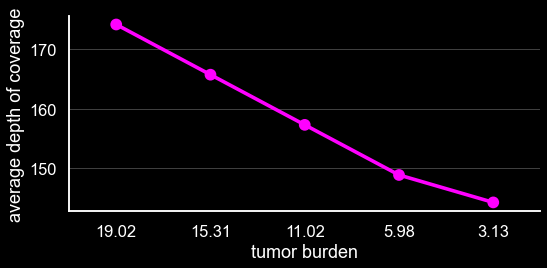

In [182]:
samples_cov = {}
for i in range(nsamples):
    samples_cov['sample_'+str(i)] = [float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "coverage_chr22_"+plasmasample1+"_"+str(dilutionseries_new[i][0])+"_"+reference+"_"+str(dilutionseries_new[i][1])+".txt")).columns)[0]),
                                     float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries_new[i][0])+"_"+reference+"_"+str(dilutionseries_new[i][1])+".txt")).columns)[0])]
print(samples_cov)


coverage_pd = pd.DataFrame.from_dict(samples_cov).T
coverage_pd.columns = ['average depth of coverage', 'tumor burden']
coverage_pd['tumor burden'] = 100*coverage_pd['tumor burden']
coverage_pd = coverage_pd.round({'tumor burden': 2}) 
sns.factorplot(x='tumor burden', y='average depth of coverage', data=coverage_pd,
            order=sorted(coverage_pd['tumor burden'].unique(), reverse=True), color='magenta', size=4, aspect=2)
        
coverage_pd

# Number of detections detected

In [20]:
samples = list(samples_dict.values())[:nsamples]
len(samples)

6

       freebayes  mutect2  strelka2  vardict  varscan
1.000       1622     1166       338    11952    25228
0.200       1619     1165       337    12071    25228
0.150       1619     1164       336    11953    25228
0.100       1619     1164       335    11953    25228
0.025       1619     1163       335    11952    25227
0.010       1619     1163       335    11952    25227
       freebayes  mutect2  strelka2  vardict  varscan
1.000        441      366        28     4159     5628
0.200        441      366        28     4182     5628
0.150        441      366        28     4159     5628
0.100        441      366        28     4159     5628
0.025        441      366        28     4159     5628
0.010        441      366        28     4159     5628
       freebayes  mutect2  strelka2  vardict  varscan
1.000        366      229       120     2367    10564
0.200        366      229       120     2400    10567
0.150        366      229       120     2367    10564
0.100        366      229   

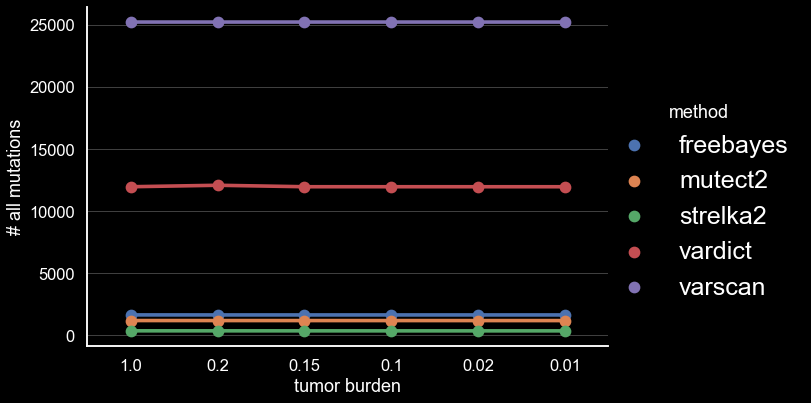

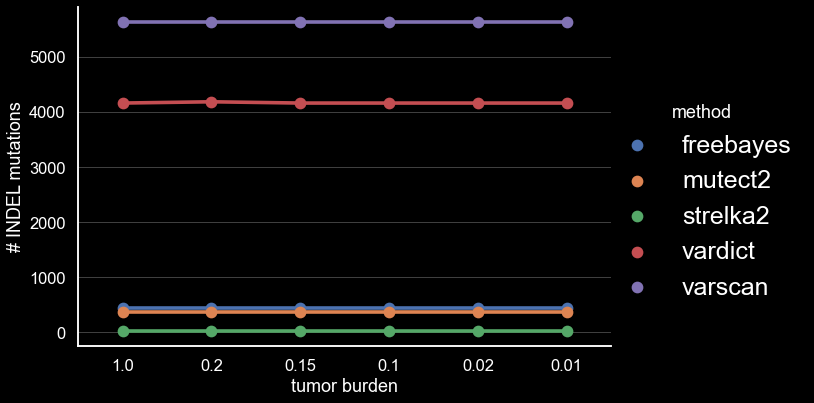

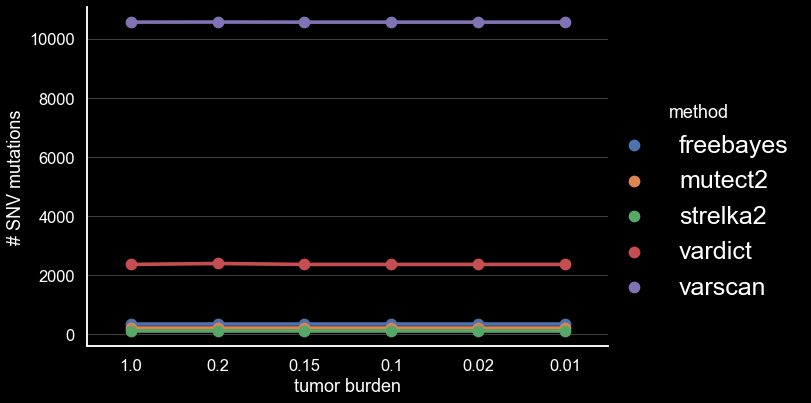

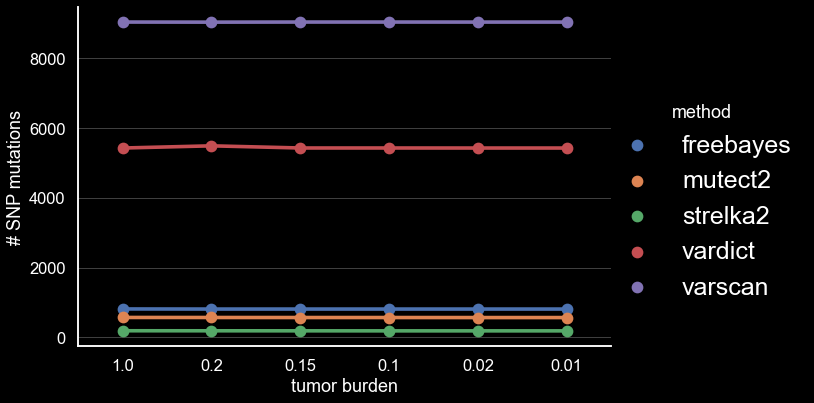

In [21]:
for mutationtype in ['all', 'INDEL', 'SNV', 'SNP']:
    numbersnvs_pd = pd.DataFrame()

    for si, s in enumerate(samples):
        nb_snv = []
        for method in methods:
            if mutationtype == 'all':
                nb_snv.append(s[s[method] == True].shape[0])
            elif mutationtype == 'INDEL':
                nb_snv.append(s[(s[method] == True) & ((s['type'] == 'INS') | (s['type'] == 'DEL'))].shape[0])
            elif mutationtype == 'SNV':
                nb_snv.append(s[(s[method] == True) & (s['type'] == 'SNV')].shape[0])
            elif mutationtype == 'SNP':
                nb_snv.append(s[(s[method] == True) & (s['type'] == 'SNP')].shape[0])
            else:
                raise ValueError('mutation type {} unknown'.format(mutationtype))
        if si == 0:
            numbersnvs_pd = pd.DataFrame.from_dict({'sample_'+ str(si): nb_snv}).T
            numbersnvs_pd.columns = methods
        else:
            numbersnvs_pd.loc['sample_'+ str(si)] = nb_snv
        numbersnvs_pd = numbersnvs_pd.rename(index=samples_tf)

    numbersnvs_pd_aux = numbersnvs_pd.reset_index()
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = pd.melt(numbersnvs_pd_aux, id_vars=['tumor burden'], value_vars=methods, var_name='method', value_name='# '+ mutationtype +' mutations')
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = numbersnvs_pd_aux.round({'tumor burden': 2}) 
    sns.catplot(x='tumor burden', y='# '+ mutationtype +' mutations', kind='point', data=numbersnvs_pd_aux, hue='method',
                height=6, aspect=1.5,
               order=sorted(numbersnvs_pd_aux['tumor burden'].unique(), reverse=True), title=mutationtype)

    print(numbersnvs_pd)

# Results with known ground truths

In [59]:
y_true_aux = pd.read_csv("../data/spikein_chr22/common_mutations_chr22/CRC_"+msstatus+"/chr22_CRC_"+msstatus+"_SNV.bed", sep='\t', header=None)
y_true_aux.columns = ['CHROM', 'POS', 'POSend', 'VAF', 'ALT']
y_true_aux['CHROM_POS'] = [str(y_true_aux['CHROM'][i]) + '_' + str(y_true_aux['POS'][i]) for i in range(y_true_aux.shape[0])]
y_true_aux.set_index('CHROM_POS', inplace=True)
y_true_aux.drop(['CHROM', "POS", 'POSend'], axis=1, inplace=True)
y_true_aux

,VAF,ALT
CHROM_POS,,
22_17416468,0.297,A
22_17703486,0.363,A
22_18185940,0.300,T
22_19129522,0.261,A
22_19144793,0.278,T
...,...,...
22_48350779,0.422,T
22_48350791,0.380,T
22_49183490,0.282,T


In [61]:
for sample in samples:
    print(sample.loc[y_true_aux.index])

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['22_18185940', '22_26509819', '22_26746148', '22_30616089',\n       '22_32403251',\n       ...\n       '22_37920861', '22_38753312', '22_48263037', '22_48350779',\n       '22_49183490'],\n      dtype='object', name='CHROM_POS', length=12). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [73]:
y_true

CHROM_POS
22_17416468    True
22_17703486    True
22_18185940    True
22_19129522    True
22_19144793    True
               ... 
22_48350779    True
22_48350791    True
22_49183490    True
22_49296008    True
22_50074717    True
Length: 92, dtype: bool

In [83]:
y_true

22_16103033    False
22_16132418    False
22_16140991    False
22_16161139    False
22_16162944    False
               ...  
22_35565664    False
22_40932909    False
22_40932920    False
22_43146877    False
22_44630242    False
Name: y_true, Length: 41086, dtype: bool

(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

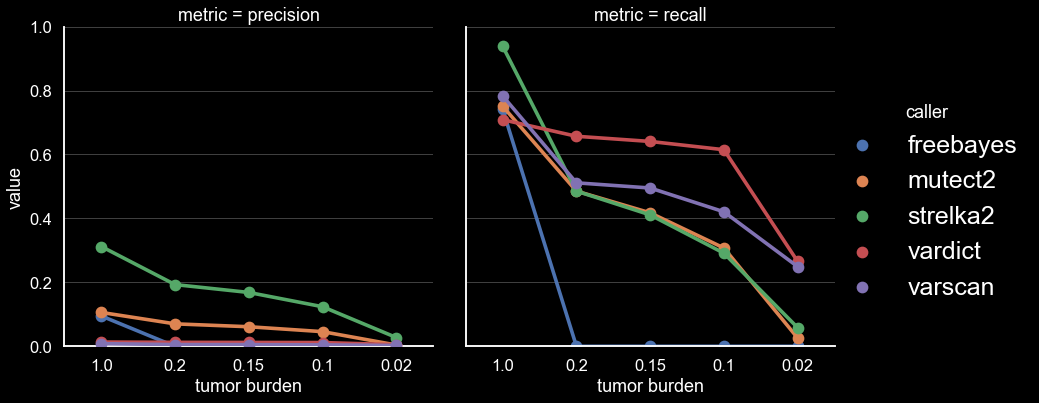

In [82]:
pd_methods = pd.DataFrame
count = 0

for mi, method in enumerate(methods):

    slist = []

    for i, sample in enumerate(samples):
        if i == 0:
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
        else:
            si = sample[['QUAL', 'type', method]]
        si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
        slist.append(si)
        

    pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

    aux = []
    for i in range(nsamples):
        aux.append('QUAL_'+str(i))
        aux.append('type_'+str(i))
        aux.append('sample_'+str(i))
    pd_method.columns = ['REF', 'ALT'] + aux
    pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
    pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
    pd_method['caller'] = method
    pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

    #if mutation == 'snv':
    #    pd_method = pd_method[pd_method['type'] == 'SNV']
    #elif mutation == 'indel':
    #    pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]

    if count == 0:
        pd_methods = pd_method
        count = 1
    else:
        pd_methods = pd.concat([pd_methods, pd_method], join='inner')
        
    y_true = pd.Series(True, index=y_true_aux.index)
    y_true.loc[y_true_aux.index] = True
    pd_methods['y_true'] = y_true
    y_true = pd_methods['y_true']
    y_true = y_true.fillna(False)

pd_results_PR = pd.DataFrame
count = 0


for mi, method in enumerate(methods):

    res_PR_df = (pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

    y_list = []
    
    for i in range(nsamples):
        y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
        y_i = y_i.fillna(False)
        y_list.append(y_i)

    res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
    res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

    res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                    var_name='metric', value_name='value')
    res_PR_df['caller'] = method
    
    if count == 0:
        pd_results_PR = res_PR_df
        count = 1
    else:
        pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')

plt.figure()
sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                capsize=.2, height=6, aspect=1,
                kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
plt.ylim([0, 1])

(0.0, 0.5)

<Figure size 432x288 with 0 Axes>

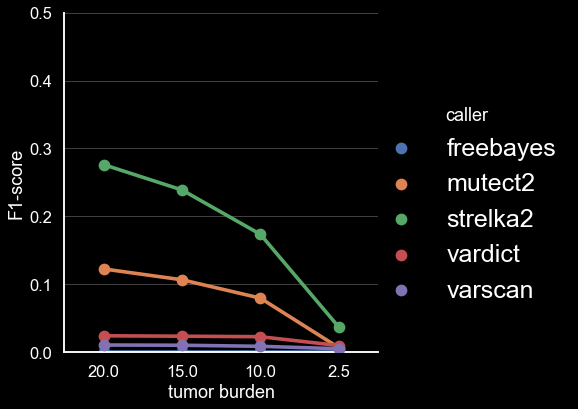

In [85]:
pd_methods = pd.DataFrame
count = 0

for mi, method in enumerate(methods):

    slist = []

    for i, sample in enumerate(samples):
        if i == 0:
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
        else:
            si = sample[['QUAL', 'type', method]]
        si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
        slist.append(si)

    pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

    aux = []
    for i in range(nsamples):
        aux.append('QUAL_'+str(i))
        aux.append('type_'+str(i))
        aux.append('sample_'+str(i))
    pd_method.columns = ['REF', 'ALT'] + aux
    pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
    pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
    pd_method['caller'] = method
    pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

    if count == 0:
        pd_methods = pd_method
        count = 1
    else:
        pd_methods = pd.concat([pd_methods, pd_method], join='inner')

pd_results = pd.DataFrame
count = 0


for mi, method in enumerate(methods):

    res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

    y_list = []
    for i in range(nsamples):
        y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
        y_i = y_i.fillna(False)
        y_list.append(y_i)


    res_df['F1-score'] = [f1_score(y_true, y_i) for y_i in y_list]  

    res_df['caller'] = method

    res_df.drop(['sample_0'], inplace=True)

    if count == 0:
        pd_results = res_df
        count = 1
    else:
        pd_results = pd.concat([pd_results, res_df], join='inner')


plt.figure()
sns.catplot(x="tumor burden", y="F1-score", hue="caller",  
                capsize=.2, height=6, aspect=1,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
plt.ylim([0, 0.5])

# Caller robustness (consensus across at least 3 methods) with original Plasma Sample as reference

37563
(39027, 16)


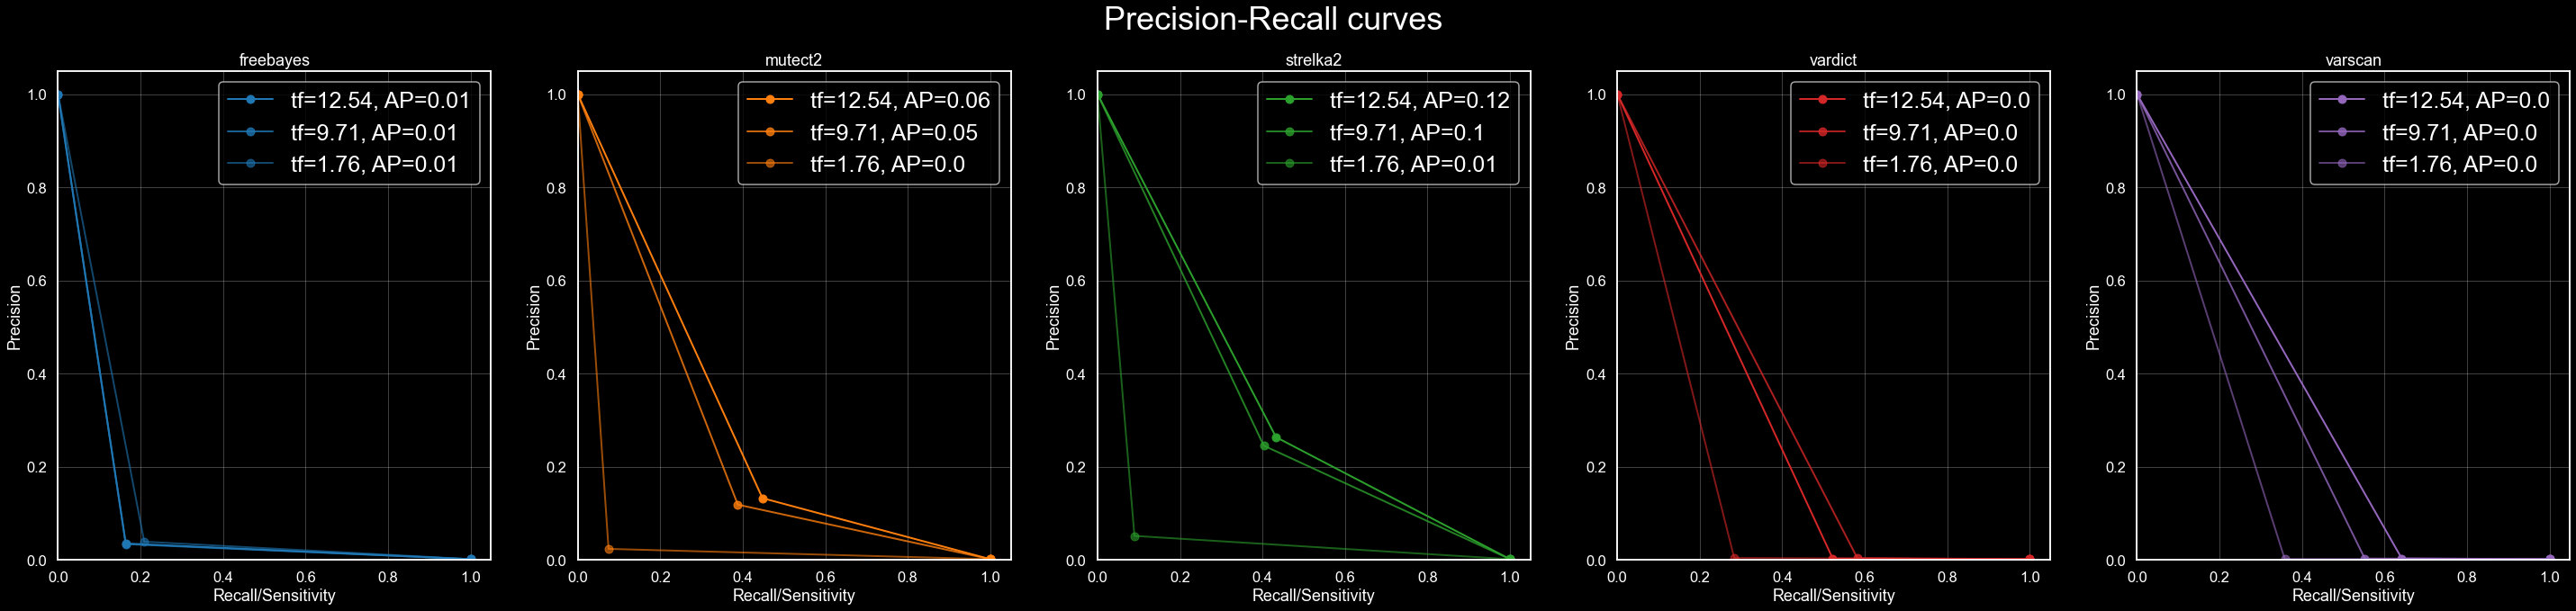

<Figure size 432x288 with 0 Axes>

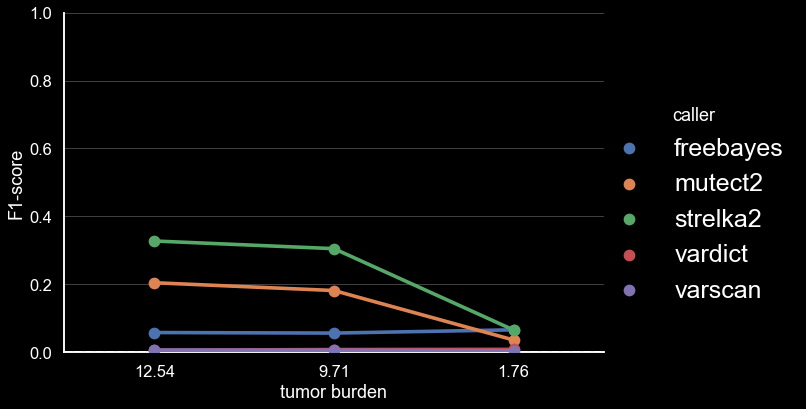

<Figure size 432x288 with 0 Axes>

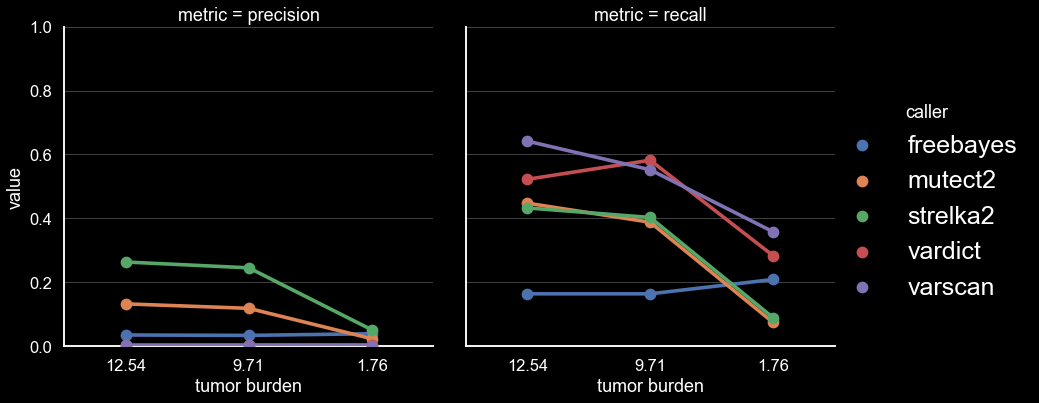

In [149]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_0', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_0'].sum()
    y_true[y_true <= 2] = 0
    #y_true = y_true.loc[indexlist]
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)

    baselineAUPRC = len(y_true[y_true == True])/len(y_true)


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        
        res_df['F1-score'] = [f1_score(y_true, y_i) for y_i in y_list]  
        #res_df['AUPRC - baseline AUPRC'] = [f1_score(y_true, y_i) - baselineAUPRC for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="F1-score", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = baselineAUPRC, color = lc, linestyle = '--') 
    plt.ylim([0, 1])
    
    #sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
    #            capsize=.2, height=6, aspect=1.5,
    #            kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    #plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    #plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=1,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 1])

35876
(37442, 19)


<Figure size 432x288 with 0 Axes>

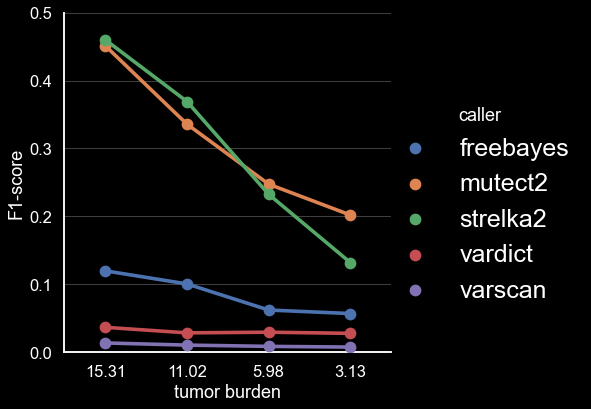

In [186]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    count = 0
    
    y_true = pd_methods[['sample_0', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_0'].sum()
    y_true[y_true <= 2] = 0
    #y_true = y_true.loc[indexlist]
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        
        res_df['F1-score'] = [f1_score(y_true, y_i) for y_i in y_list]  

        res_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        
        if count == 0:
            pd_results = res_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')


    plt.figure()
    sns.catplot(x="tumor burden", y="F1-score", hue="caller",  
                    capsize=.2, height=6, aspect=1,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.ylim([0, 0.5])

# Within caller consistency with both original Plasma Sample as reference

In [24]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        sbis = samples_dict['sample_0_bis'][['REF', 'ALT', 'QUAL', 'type', method]]
        sbis.rename(columns = {method:'sample_0_bis'},  inplace = True)
        sbis = sbis.loc[~sbis.index.duplicated(keep=("first"))]
        slist.append(sbis)
        
        #pd_method = pd.concat(slist, axis=1)
        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        
        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_0_bis', 'type_0_bis', 'sample_0_bis']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_0_bis'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_0_bis']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        
        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method][['sample_0', 'sample_0_bis']]
        y_true['ref'] = y_true['sample_0'] & y_true['sample_0_bis']
        y_true.index.name = 'CHROM_POS'
        y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
        y_true = y_true.astype(bool)
        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = color_list[mi], linestyle = '--') 
    plt.ylim([0, 1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

KeyboardInterrupt: 

# Caller robustness (consensus across at least 3 methods) with both original Plasma Sample as reference

In [25]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        sbis = samples_dict['sample_0_bis'][['REF', 'ALT', 'QUAL', 'type', method]]
        sbis.rename(columns = {method:'sample_0_bis'},  inplace = True)
        sbis = sbis.loc[~sbis.index.duplicated(keep=("first"))]
        slist.append(sbis)
        
        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        
        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_0_bis', 'type_0_bis', 'sample_0_bis']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_0_bis'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_0_bis']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        
        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_0', 'sample_0_bis', 'caller']]
    y_true['ref'] = pd_methods['sample_0'] & pd_methods['sample_0_bis']
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.5])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.2])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

KeyboardInterrupt: 

(0.0, 0.2)

<Figure size 432x288 with 0 Axes>

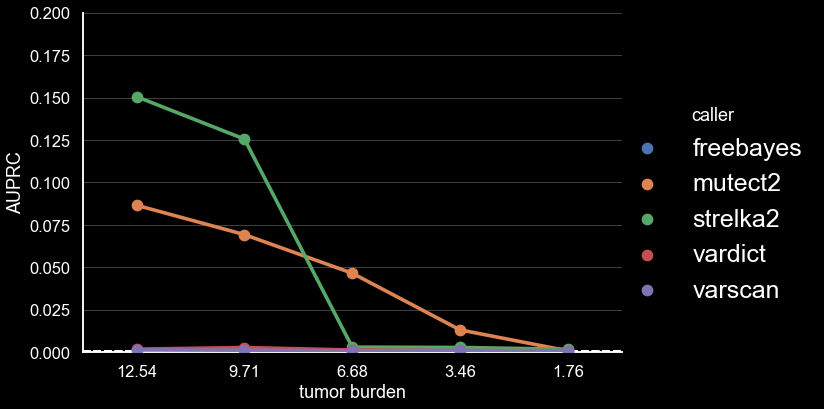

In [80]:
plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
for mi, method in enumerate(methods):
    plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
plt.ylim([0, 0.2])

# Within caller consistency in the tumor as reference

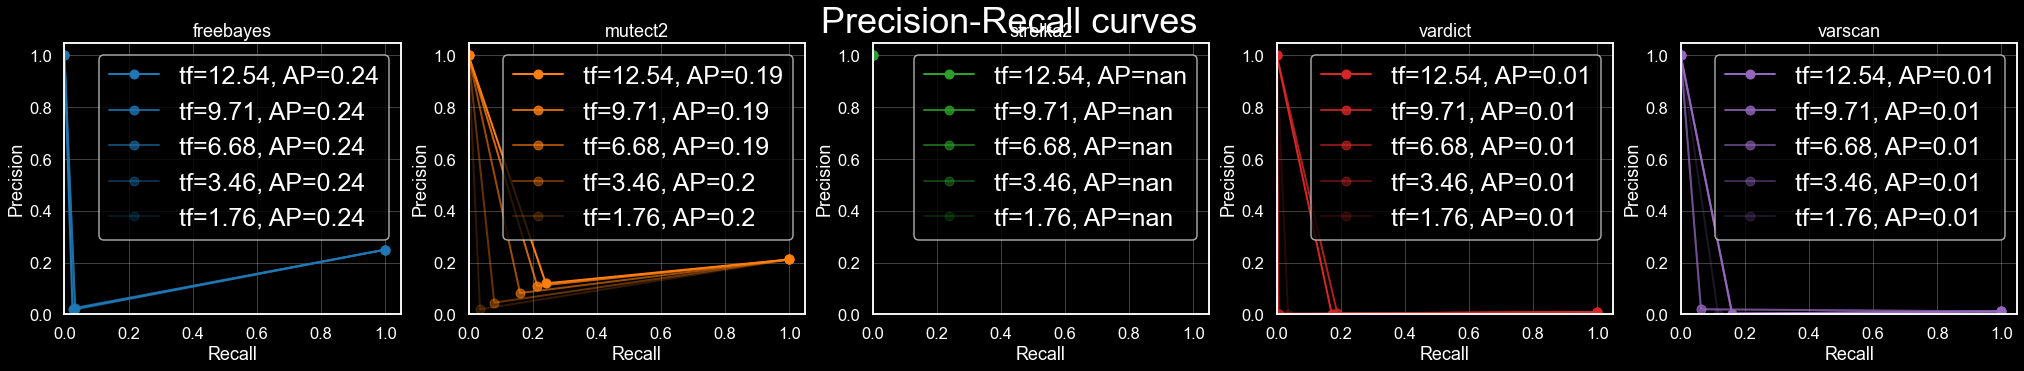

<Figure size 432x288 with 0 Axes>

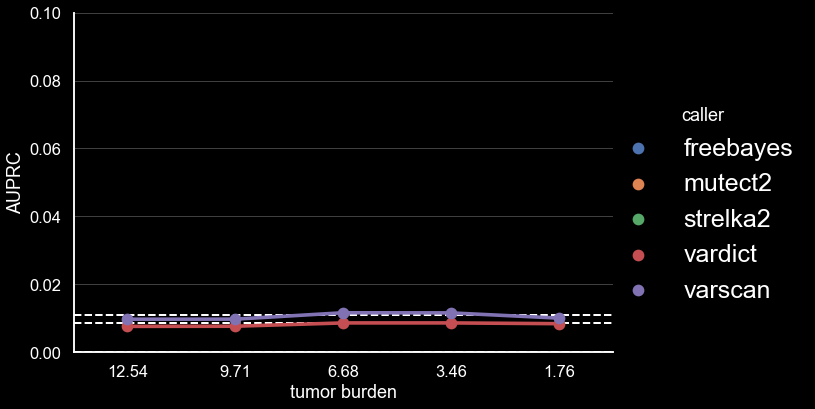

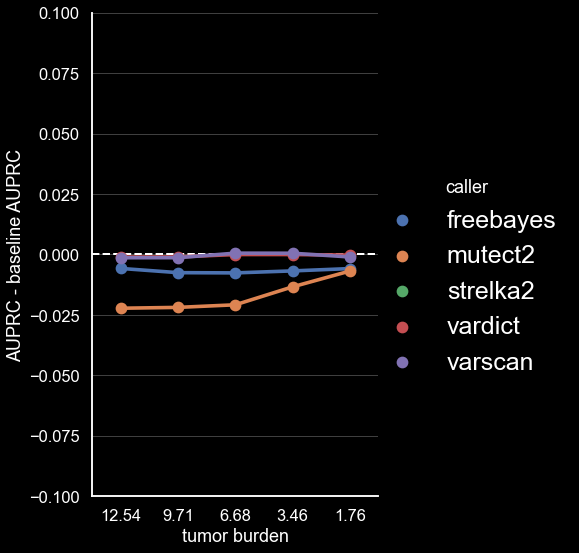

<Figure size 432x288 with 0 Axes>

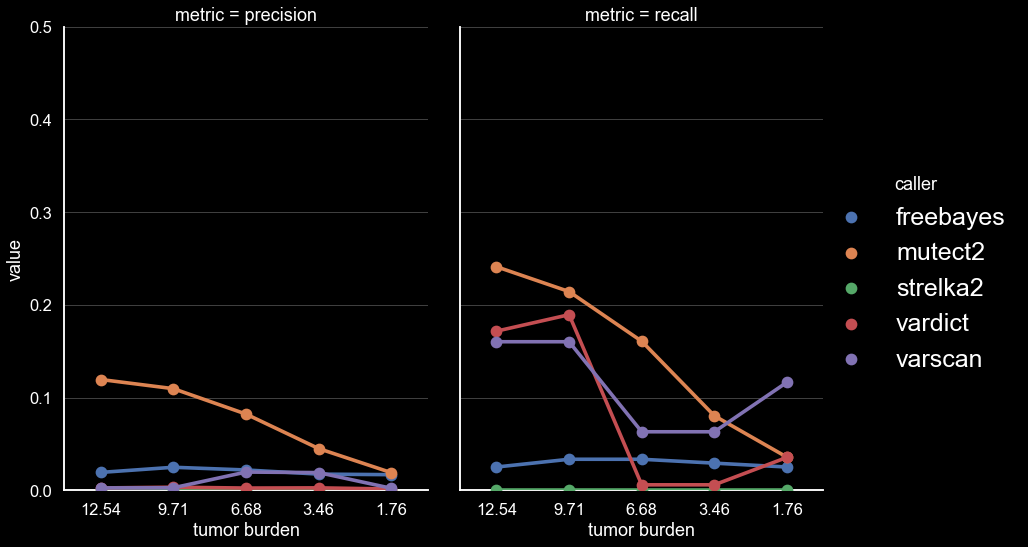

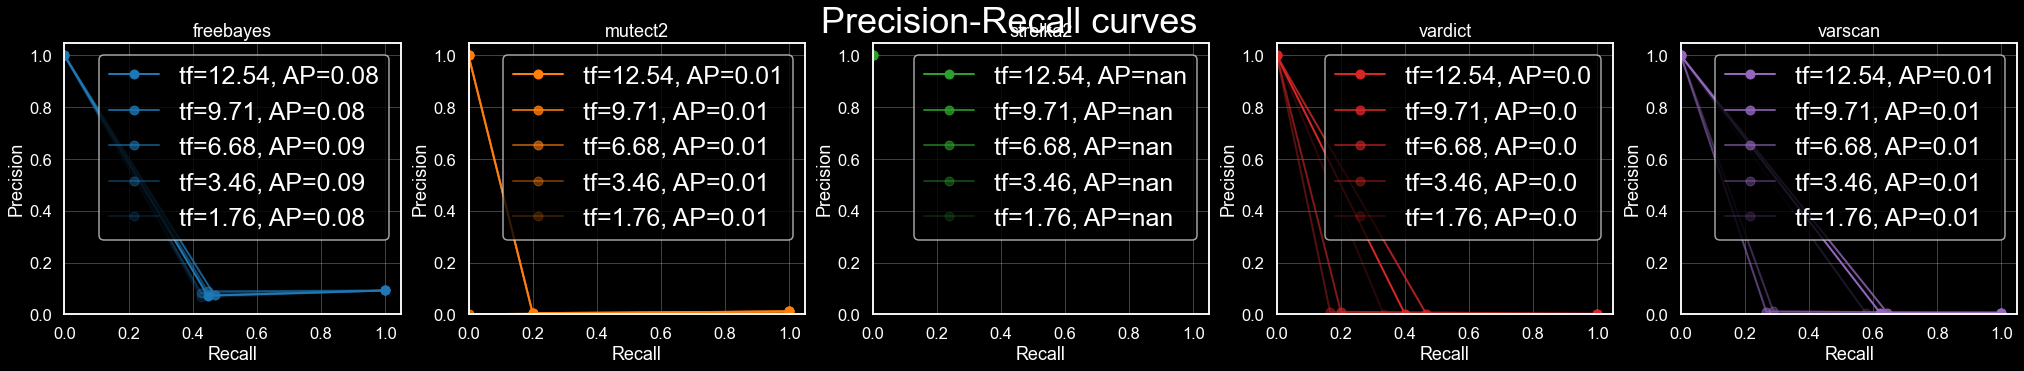

<Figure size 432x288 with 0 Axes>

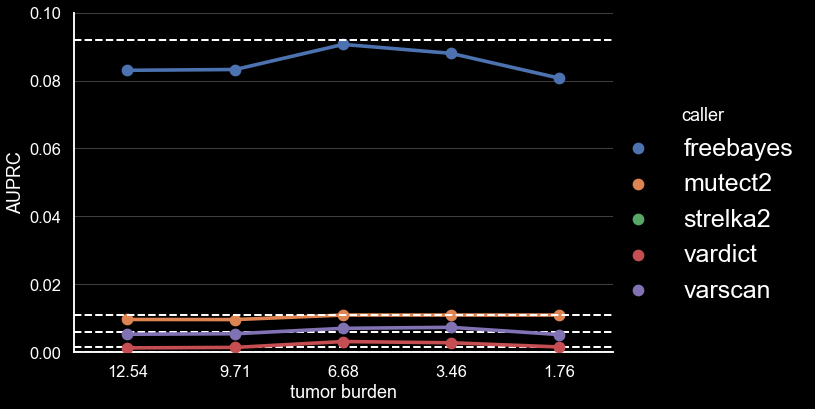

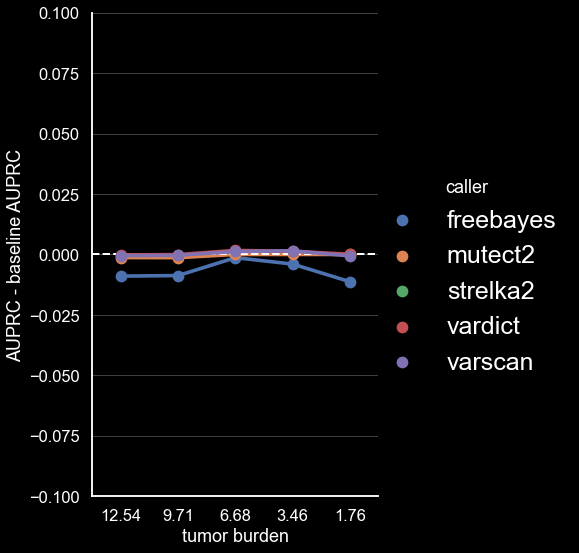

<Figure size 432x288 with 0 Axes>

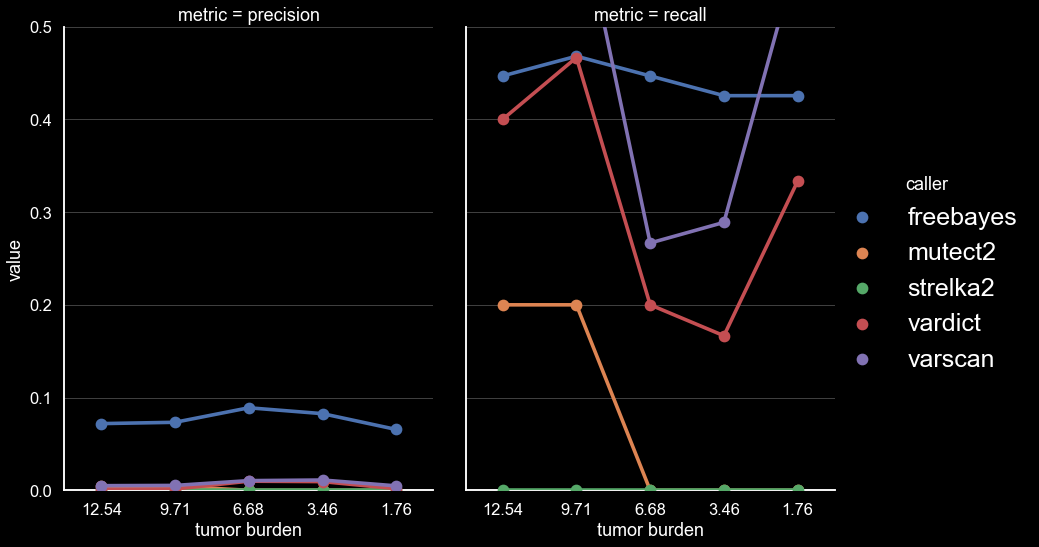

In [81]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        st = st.loc[~st.index.duplicated(keep=("first"))]
        slist.append(st)

        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_t'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_t'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

38069


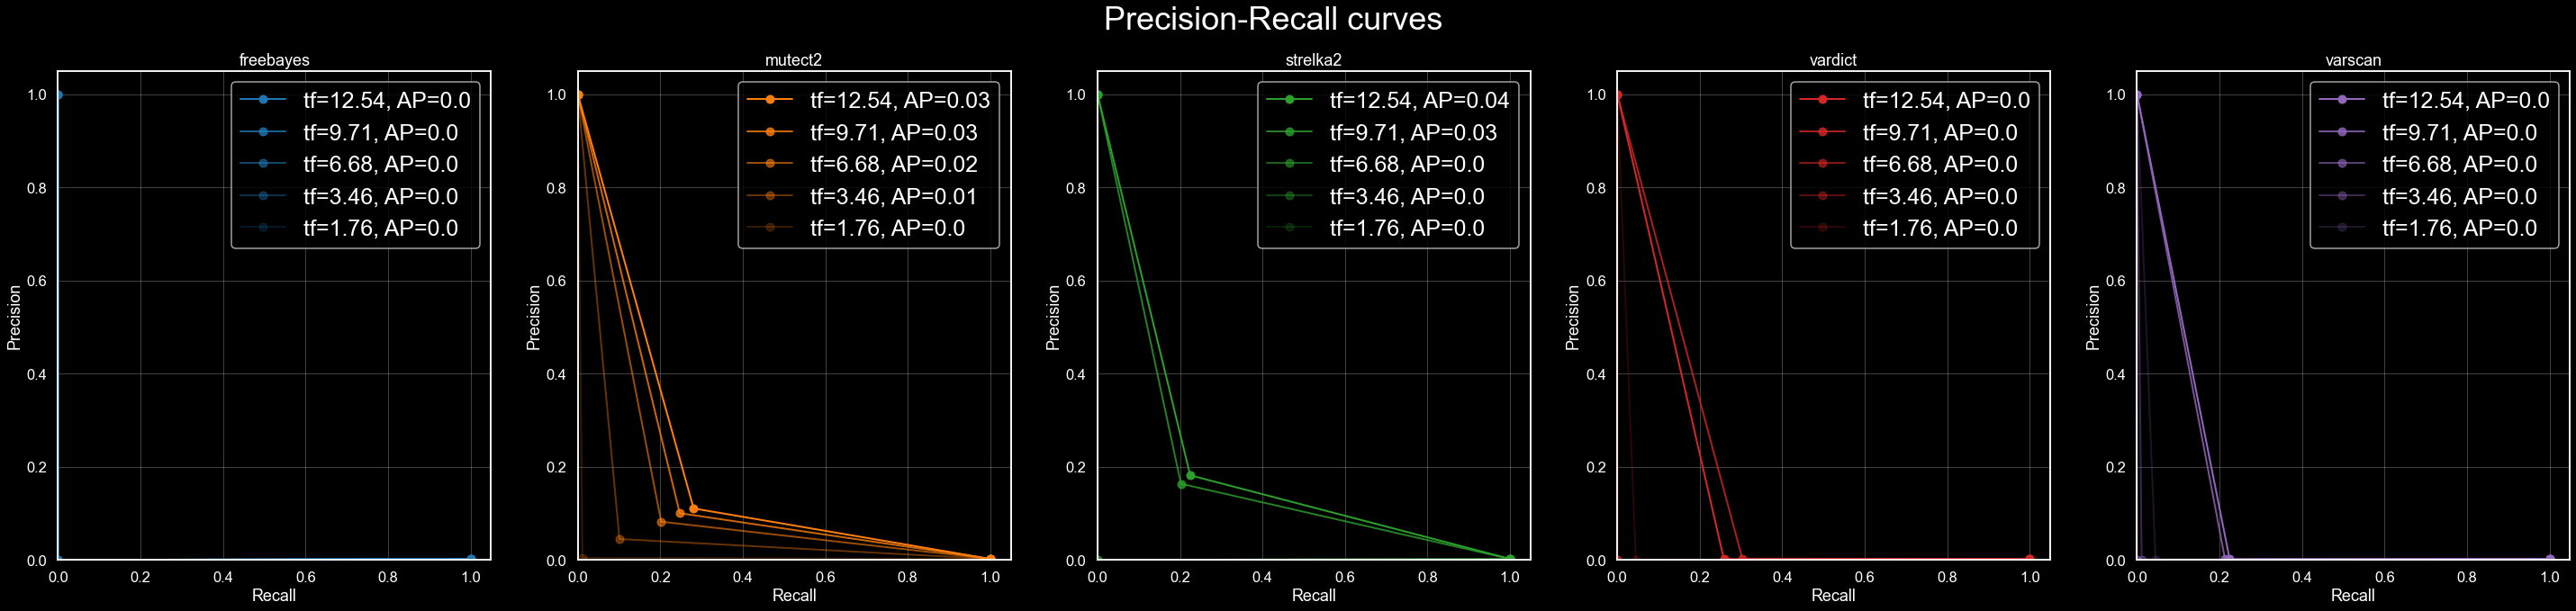

<Figure size 432x288 with 0 Axes>

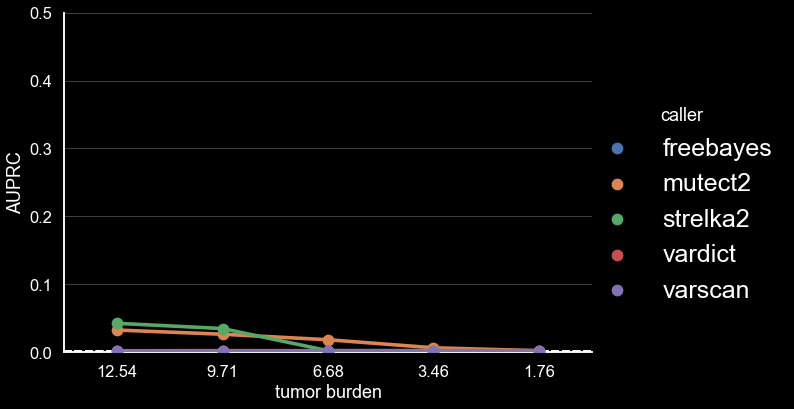

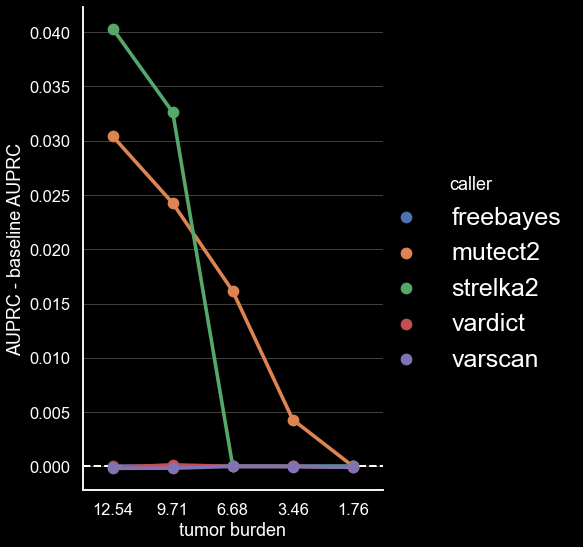

<Figure size 432x288 with 0 Axes>

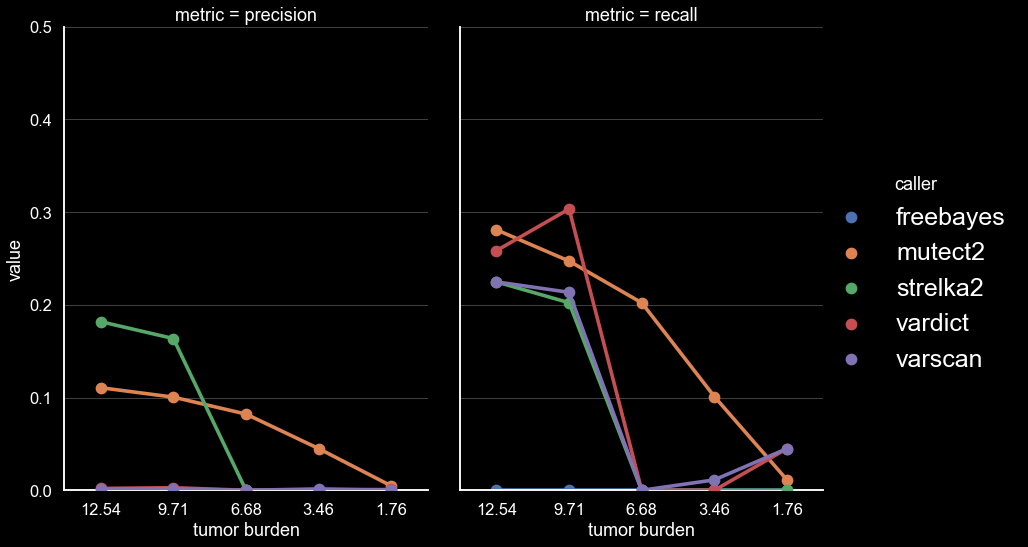

In [20]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        st = st.loc[~st.index.duplicated(keep=("first"))]
        slist.append(st)

        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_t'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.2])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

(0.0, 0.2)

<Figure size 432x288 with 0 Axes>

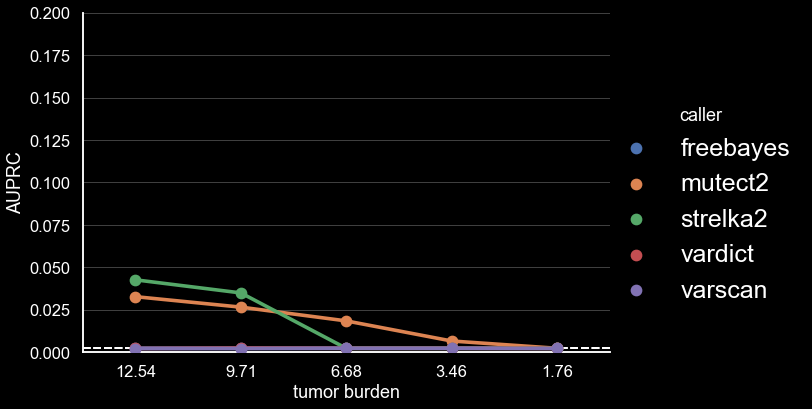

In [21]:
plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
for mi, method in enumerate(methods):
    plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
plt.ylim([0, 0.2])

In [22]:
for mutation in ['snv']: #, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']):

        s0 = sample_0[['REF', 'ALT', 'QUAL', 'type', method]]
        s0.rename(columns = {method:'sample_0'},  inplace = True)
        st = sample_t[['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        s1 = sample_1[['REF', 'ALT', 'QUAL', 'type', method]]
        s1.rename(columns = {method:'sample_1'},  inplace = True)
        s2 = sample_2[['REF', 'ALT', 'QUAL', 'type', method]]
        s2.rename(columns = {method:'sample_2'},  inplace = True)
        s3 = sample_3[['REF', 'ALT', 'QUAL', 'type', method]]
        s3.rename(columns = {method:'sample_3'},  inplace = True)
        #s4 = sample_4[['REF', 'ALT', 'QUAL','type', method]]
        #s4.rename(columns = {method:'sample_4'},  inplace = True)
        #s5 = sample_5[['REF', 'ALT', 'QUAL','type', method]]
        #s5.rename(columns = {method:'sample_5'},  inplace = True)

        pd_method = pd.concat([s0.loc[~s0.index.duplicated()],
               st.loc[~st.index.duplicated()],
               s1.loc[~s1.index.duplicated()],
               s2.loc[~s2.index.duplicated()],
               s3.loc[~s3.index.duplicated()],
               s4.loc[~s4.index.duplicated()],
               s5.loc[~s5.index.duplicated()]], axis=1)

        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        pd_method.columns = ['REF', 'ALT', 'QUAL_0', 'type_0', 'sample_0','QUAL_t', 'type_t', 'sample_t', 'QUAL_1', 'type_1', 'sample_1', 'QUAL_2', 'type_2', 'sample_2',  'QUAL_3', 'type_3', 'sample_3', 'QUAL_4', 'type_4', 'sample_4', 'QUAL_5', 'type_5', 'sample_5']
        pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']] = pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].fillna(value=False)
        #pd_method.drop(pd_method[pd_method['sample_0'] + pd_method['sample_0_bis']+ pd_method['sample_1'] + pd_method['sample_2'] + pd_method['sample_3'] + pd_method['sample_4'] == False].index, axis=0, inplace=True)
        pd_method[['REF', 'sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].head()
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_0','type_t','type_1', 'type_2', 'type_3', 'type_4', 'type_5']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]

        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame.empty
    pd_results_PR = pd.DataFrame.empty
    count = 0

    fig, axs = plt.subplots(1,5,figsize=(30, 4))
    fig.suptitle('Precision-Recall curves')


    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])



    baselineAUPRC = {}

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool) + pd_methods[pd_methods['caller'] == method]['sample_0_bis'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)

        y_0 = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool).reindex(y_true.index).squeeze()
        y_0 = y_0.fillna(False)
        y_1 = pd_methods[pd_methods['caller'] == method]['sample_1'].astype(bool).reindex(y_true.index).squeeze()
        y_1 = y_1.fillna(False)
        y_2 = pd_methods[pd_methods['caller'] == method]['sample_2'].astype(bool).reindex(y_true.index).squeeze()
        y_2 = y_2.fillna(False)
        y_3 = pd_methods[pd_methods['caller'] == method]['sample_3'].astype(bool).reindex(y_true.index).squeeze()
        y_3 = y_3.fillna(False)
        y_4 = pd_methods[pd_methods['caller'] == method]['sample_4'].astype(bool).reindex(y_true.index).squeeze()
        y_4 = y_4.fillna(False)
        y_5 = pd_methods[pd_methods['caller'] == method]['sample_5'].astype(bool).reindex(y_true.index).squeeze()
        y_5 = y_5.fillna(False)

        res_df['AUPRC'] = [average_precision_score(y_true, y_0),
                          average_precision_score(y_true, y_1),
                          average_precision_score(y_true, y_2),
                          average_precision_score(y_true, y_3),
                          average_precision_score(y_true, y_4),
                          average_precision_score(y_true, y_5),
                         ]
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_0) - baselineAUPRC[method],
                      average_precision_score(y_true, y_1) - baselineAUPRC[method],
                      average_precision_score(y_true, y_2) - baselineAUPRC[method],
                      average_precision_score(y_true, y_3) - baselineAUPRC[method],
                      average_precision_score(y_true, y_4) - baselineAUPRC[method],
                      average_precision_score(y_true, y_5) - baselineAUPRC[method],

                     ]
        res_PR_df['precision'] = [precision_score(y_true, y_0),
                          precision_score(y_true, y_1),
                          precision_score(y_true, y_2),
                          precision_score(y_true, y_3),
                          precision_score(y_true, y_4),
                          precision_score(y_true, y_5),
                         ]

        res_PR_df['recall'] = [recall_score(y_true, y_0),
                          recall_score(y_true, y_1),
                          recall_score(y_true, y_2),
                          recall_score(y_true, y_3),
                          recall_score(y_true, y_4),
                          recall_score(y_true, y_5),
                         ]
        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method
        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, 6], inplace=True)

        # Plot Precision-Recall curve
        alpha_list = [0, 1, .8, .6, .4, .2, .1]
        for i in range(1,6):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=4, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results, legend=False)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    #plt.ylim([0, 0.5])
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    #plt.ylim([0, 0.5])

NameError: name 'sample_0' is not defined

- Histograms of true allele frequencies in each tumor sample. Note how increasing admixture increases the prevalence of low- frequency variants.
- Benchmarking results for germline SNVs
- Benchmarking results for somatic SNVs on exome data.
- averaged over the four replicates

- add fake mutations on healthy mixtures

In [39]:
cov_pd = pd.read_csv('../data/CRC-986_300316_cov.txt', header=None)
cov_pd.index = [i for i in range(1,1002)]
cov_pd

,0
1,1880935
2,1312716
3,1171549
4,1492055
5,1900432
...,...
997,15728
998,15821
999,16007
1000,16136


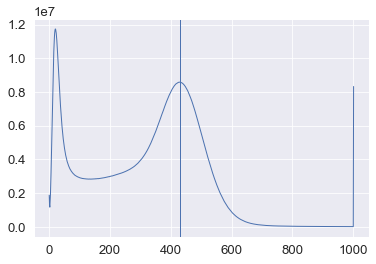

In [52]:
plt.plot(cov_pd.index, cov_pd.values)
plt.axvline(430)

In [43]:
cov_pd.describe()

,0
count,1.001000e+03
mean,2.844013e+06
std,2.883503e+06
min,1.572800e+04
25%,5.442400e+04
50%,2.855419e+06
75%,4.320742e+06
max,1.174217e+07


([<matplotlib.axis.YTick at 0x7fb178a59b50>,
 [Text(0, 0.0, '0'),
  Text(0, 0.1, ''),
  Text(0, 0.2, ''),
  Text(0, 0.30000000000000004, ''),
  Text(0, 0.4, ''),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, ''),
  Text(0, 0.7000000000000001, ''),
  Text(0, 0.8, ''),
  Text(0, 0.9, ''),
  Text(0, 1.0, '1')])

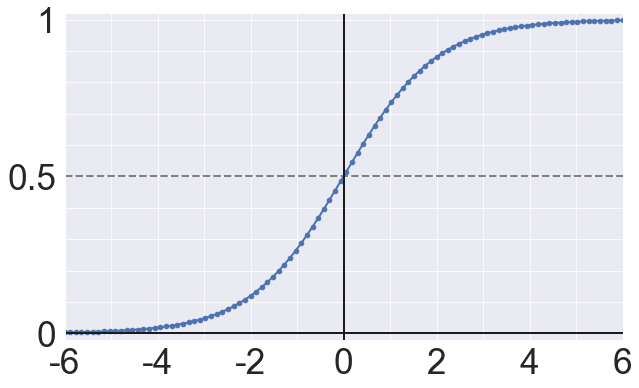

In [102]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0)) #, label='w=1, b=0')
#plt.scatter(x, sigmoid(x, 10, 0))
#plt.plot(x, sigmoid(x, 10, 0), lw=2, label='w=10, b=0')
#plt.scatter(x, sigmoid(x, 0.1, 0))
#plt.plot(x, sigmoid(x, 0.1, 0), lw=2, label='w=0.1, b=0')
#plt.plot(x, sigmoid(x, 1, 1), label='w=1, b=1')
#plt.plot(x, sigmoid(x, 1, -1), label='w=1, b=-1')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
#plt.xlabel('z')
#plt.ylabel('sigma(w.z+b)')
#plt.legend()

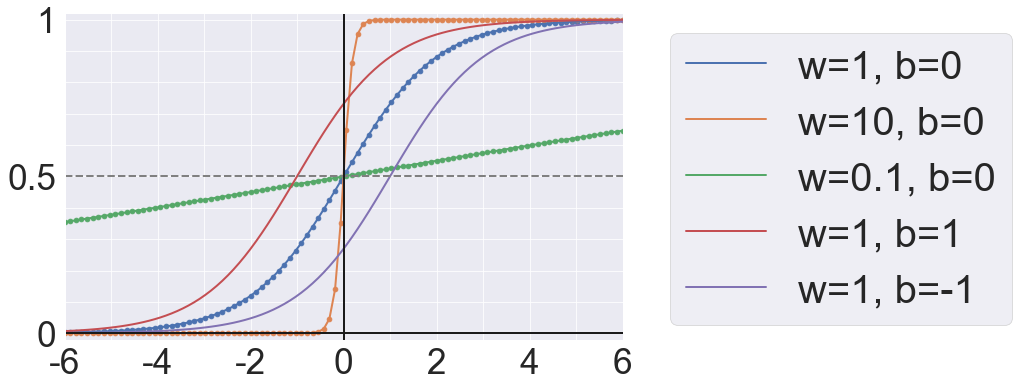

In [109]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0), label='w=1, b=0')
plt.scatter(x, sigmoid(x, 10, 0))
plt.plot(x, sigmoid(x, 10, 0), label='w=10, b=0')
plt.scatter(x, sigmoid(x, 0.1, 0))
plt.plot(x, sigmoid(x, 0.1, 0),  label='w=0.1, b=0')
plt.plot(x, sigmoid(x, 1, 1), label='w=1, b=1')
plt.plot(x, sigmoid(x, 1, -1), label='w=1, b=-1')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

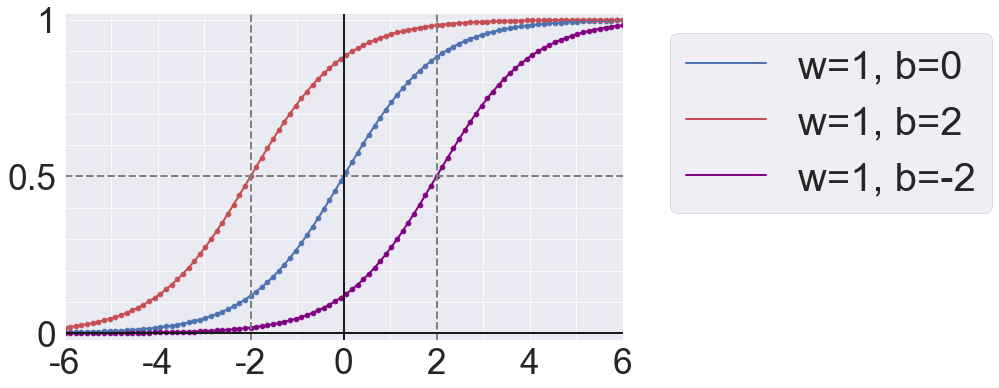

In [115]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0), label='w=1, b=0')
plt.scatter(x, sigmoid(x, 1, 2), c='r')
plt.plot(x, sigmoid(x, 1, 2), label='w=1, b=2', c='r')
plt.scatter(x, sigmoid(x, 1, -2), c='purple')
plt.plot(x, sigmoid(x, 1, -2), label='w=1, b=-2', c='purple')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(-2, c='grey', ls='--')
plt.axvline(2, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')